# King Couty Real Estate

# Table of Contents

*[Feature Engineering](#feateng)<br>
    
*[Baseline Model](#basemod)<br>
    
*[Exploration](#exp)<br>
    
*[Improved Models](#impmods)<br>
    **[Highest R-squared Model](#hir)<br>
    **[Lowest Cond. No. Model with R-squared > .6](#abv6mod)<br>
    **[Model with Renovation Features](#renomod)<br>
    
*[Non-Model Analysis](#nonmods)<br>
    

In [1]:
# Import libraries

import itertools
import numpy as np
import pandas as pd 
from numbers import Number
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
import math

In [2]:
# load data

df = pd.read_csv('data/kc_house_data.csv')

# Feature Engineering <a class="anchor" id="feateng"></a>

In [3]:
# Drop nulls and remove rows with loacation outside of Washington state, reset index

df = df.dropna()

df = df[(df.lat > 47.087) &
        (df.lat < 47.779) &
        (df.long > -122.527) &
        (df.long < -121.064)]

df.reset_index(drop=True, inplace=True)

In [4]:
# Create a column of mean prices by zip

# Get zip code form address

df_split = df.address.str.replace(',', '').str.split(' ')
zips = []
numbers = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
for x in df_split:
    for y in x:
        if (y[0] == '9') & (len(y) == 5):
            zips.append(y)
for x in zips:
    if x[1] != '8':
        zips.remove(x)
df['zips'] = pd.Series(zips)

#Create dict of mean prices by zip code
zips_avg_prices = df.groupby(df.zips).mean()['price']
zips_mean_dict = zips_avg_prices.to_dict()

# Map mean proce by zip into new column
df['zip_mean'] = df['zips'].map(zips_mean_dict)
df['zip_mean']

# Create zip price mean category column

price_cat = []

for price in df['zip_mean']:
    if price < 714997.7:
        price_cat.append(1)
    elif price < 1320000:
        price_cat.append(2)
    else:
        price_cat.append(3)
        
df['price_cat'] = price_cat

In [5]:
#Explore dataframe

# df.head()
# df.tail()
# df.info()
# df.describe()
# df.columns

In [6]:
# Find the zipcode with the highest  
sorted(zips_mean_dict.items(), key=lambda x:x[1], reverse=True)

[('98039', 5319169.508474576),
 ('98004', 3706461.8291925467),
 ('98040', 2761960.3209169055),
 ('98005', 2166382.2359550563),
 ('98033', 2035934.7944078948),
 ('98112', 1933852.309446254),
 ('98075', 1903188.7250608273),
 ('98006', 1871561.5931558935),
 ('98074', 1707086.0702576113),
 ('98077', 1638786.7510204082),
 ('98050', 1600500.0),
 ('98102', 1589429.5347222222),
 ('98109', 1588213.3100775194),
 ('98052', 1564485.2394366197),
 ('98053', 1562473.554707379),
 ('98029', 1560072.0031152647),
 ('98024', 1539561.1228070175),
 ('98008', 1533385.7481108312),
 ('98199', 1528086.3609756099),
 ('98119', 1518790.539419087),
 ('98105', 1515511.4575757575),
 ('98072', 1493119.5247813412),
 ('98007', 1409664.344155844),
 ('98027', 1379831.4188481676),
 ('98177', 1341786.3189368772),
 ('98034', 1293053.0043541365),
 ('98122', 1229700.240909091),
 ('98011', 1205783.2413793104),
 ('98115', 1178231.2065789474),
 ('98065', 1173838.448630137),
 ('98116', 1126388.3850129198),
 ('98028', 1082302.82808

In [7]:
# Encode ordinals

data_categorical = pd.DataFrame(df.select_dtypes("object")).drop(['date','address'], axis=1)
ordinal_data = data_categorical[['view', 'condition', 'grade']]

# Ordinal encode 'view' and create df for concat

view_ord_cats = [['NONE', 'FAIR', 'AVERAGE', 'GOOD', 'EXCELLENT']]

view_ords = OrdinalEncoder(categories=view_ord_cats)

view_ords.fit(pd.DataFrame(ordinal_data['view']))
view_encoded = view_ords.transform(pd.DataFrame(ordinal_data['view']))
view_encoded

view_enc = pd.DataFrame(view_encoded, columns=['view_enc'])

# Ordinal encode 'condition' and create df for concat

condition_ord_cats = [['Poor', 'Fair', 'Average', 'Good', 'Very Good']]

cond_ords = OrdinalEncoder(categories=condition_ord_cats)
cond_ords.fit(pd.DataFrame(ordinal_data['condition']))
cond_encoded = cond_ords.transform(pd.DataFrame(ordinal_data['condition']))
cond_encoded

cond_enc = pd.DataFrame(cond_encoded, columns=['cond_enc'])
cond_enc

# Ordinal encode 'grade' and create df for concat

grade_ord_cats = [['1', '2 Substandard','3 Poor', '4 Low', '5 Fair', '6 Low Average', '7 Average', '8 Good', '9 Better', '10 Very Good', '11 Excellent', '12 Luxury', '13 Mansion']]

grade_ords = OrdinalEncoder(categories=grade_ord_cats)
grade_ords.fit(pd.DataFrame(ordinal_data['grade']))
grade_encoded = grade_ords.transform(pd.DataFrame(ordinal_data['grade']))
grade_encoded

grade_enc = pd.DataFrame(grade_encoded, columns=['grade_enc'])

In [8]:
# Create dummy columns of non-ordinal category data

cat_data = pd.DataFrame(df.select_dtypes("object")).drop(['date','address', 'zips'], axis=1)

cat_dums = pd.get_dummies(cat_data)
cat_dums = cat_dums.add_suffix('_dum')

In [9]:
# Concatonate numerical and encoded features

# Concat ordinal dfs
ords_conc = pd.concat([view_enc, cond_enc, grade_enc], axis=1)

# Get numerical data
data_numerical = df._get_numeric_data()
data_numerical

#Keep Zips

zips = df['zips']

#Concatonate all
concat_all = pd.concat([data_numerical, zips, ords_conc, cat_dums], axis=1)

# Set df to new df (concat_all)
df = concat_all
df

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,...,heat_source_Electricity/Solar_dum,heat_source_Gas_dum,heat_source_Gas/Solar_dum,heat_source_Oil_dum,heat_source_Oil/Solar_dum,heat_source_Other_dum,sewer_system_PRIVATE_dum,sewer_system_PRIVATE RESTRICTED_dum,sewer_system_PUBLIC_dum,sewer_system_PUBLIC RESTRICTED_dum
0,7399300360,675000.0,4,1.0,1180,7140,1.0,1180,0,0,...,0,1,0,0,0,0,0,0,1,0
1,8910500230,920000.0,5,2.5,2770,6703,1.0,1570,1570,0,...,0,0,0,1,0,0,0,0,1,0
2,1180000275,311000.0,6,2.0,2880,6156,1.0,1580,1580,0,...,0,1,0,0,0,0,0,0,1,0
3,1604601802,775000.0,3,3.0,2160,1400,2.0,1090,1070,200,...,0,1,0,0,0,0,0,0,1,0
4,8562780790,592500.0,2,2.0,1120,758,2.0,1120,550,550,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29172,7834800180,1555000.0,5,2.0,1910,4000,1.5,1600,1130,0,...,0,0,0,1,0,0,0,0,1,0
29173,194000695,1313000.0,3,2.0,2020,5800,2.0,2020,0,0,...,0,1,0,0,0,0,0,0,1,0
29174,7960100080,800000.0,3,2.0,1620,3600,1.0,940,920,240,...,0,1,0,0,0,0,0,0,1,0
29175,2781280080,775000.0,3,2.5,2570,2889,2.0,1830,740,480,...,0,1,0,0,0,0,0,0,1,0


In [10]:
# Create binary for grade above average

gr_above_avg = []
for x in df['grade_enc']:
    if x > 7:
        gr_above_avg.append(1)
    else:
        gr_above_avg.append(0)
        
df['gr_above_avg'] = pd.Series(gr_above_avg)
        
cond_above_avg = []
for x in df['cond_enc']:
    if x > 2:
        cond_above_avg.append(1)
    else:
        cond_above_avg.append(0)

df['cond_above_avg'] = pd.Series(cond_above_avg)
        
view_above_avg = []
for x in df['view_enc']:
    if x > 2:
        view_above_avg.append(1)
    else:
        view_above_avg.append(0)

df['view_above_avg'] = pd.Series(view_above_avg)

In [11]:
# Create price categories from mean price of zips

price_cat = []

for price in df['zip_mean']:
    if price < 714997.7:
        price_cat.append(1)
    elif price < 1320000:
        price_cat.append(2)
    else:
        price_cat.append(3)
        
df['price_cat'] = price_cat

In [12]:
# Create square foot categories from sqft_living

sqft_cat = []

for sqft in df['sqft_living']:
    if sqft < 1000:
        sqft_cat.append(1)
    elif sqft < 1500:
        sqft_cat.append(2)
    elif sqft < 2000:
        sqft_cat.append(3)
    elif sqft < 2500:
        sqft_cat.append(4)
    elif sqft < 3000:
        sqft_cat.append(5)
    elif sqft < 3500:
        sqft_cat.append(6)
    elif sqft < 4000:
        sqft_cat.append(7)
    elif sqft < 4500:
        sqft_cat.append(8)
    else:
        sqft_cat.append(9)
        
df['sqft_cat'] = sqft_cat

In [13]:
# Create binary for house features - garage, basement, patio

df['has_garage'] = [1 if x > 0 else 0 for x in df['sqft_garage']]
df['has_basement'] = [1 if x > 0 else 0 for x in df['sqft_basement']]
df['has_patio'] = [1 if x > 0 else 0 for x in df['sqft_patio']]

In [14]:
# Create feature of distance from a point of high prices

df_map = df.copy()
df_map['locat'] = list(zip(df_map.long, df_map.lat))

def haversineSeattle(coord):
    lon, lat = coord
    lonS, latS = (-122.236572, 47.626480)
    
    R = 6371000  # radius of Earth in meters
    phi = math.radians(lat)
    phi_S = math.radians(latS)
    
    delta_phi = math.radians(latS - lat)
    delta_lambda = math.radians(lonS - lon)
    a = math.sin(delta_phi / 2.0) ** 2 + math.cos(phi) * math.cos(phi_S) * math.sin(delta_lambda / 2.0) ** 2
    
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    km = (R * c) / 1000  # output distance in kilometers

    km = round(km, 3)

    return km

distance = []
for x in df_map.locat:
    distance.append(haversineSeattle(x))
df['dist_high_zip'] = pd.Series(distance)

In [15]:
# Remove outliers

# Create function that identifies outliers

def find_outliers_IQR(df):
   q1=df.quantile(0.25)
   q3=df.quantile(0.75)
   IQR=q3-q1
   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
   return outliers

def get_outliers(df):
    outliers = find_outliers_IQR(df)
    print('number of outliers: '+ str(len(outliers)))
    print('max outlier value: '+ str(outliers.max()))
    print('min outlier value: '+ str(outliers.min()))
    return print(outliers)

# Remove rows with outliers from dataframe. Currently min outliers are hard coded below after running get_outliers function

df_less_outs = df[df['price'] < 2309000]
df_less_outs = df_less_outs[df_less_outs['sqft_living'] < 4450]
df_less_outs = df_less_outs[df_less_outs['sqft_above'] < 3950]
df = df_less_outs

In [16]:
# Check correlation to price

df.corr()['price'].map(abs).sort_values(ascending=False)[0:15]

price                      1.000000
zip_mean                   0.635232
price_cat                  0.600768
sqft_living                0.550074
sqft_cat                   0.542344
grade_enc                  0.536595
sqft_above                 0.456631
lat                        0.435948
gr_above_avg               0.431669
bathrooms                  0.420699
dist_high_zip              0.396717
grade_9 Better_dum         0.336263
bedrooms                   0.301194
grade_7 Average_dum        0.265335
grade_6 Low Average_dum    0.254496
Name: price, dtype: float64

# Baseline Model <a class="anchor" id="#basemod"></a>

In [17]:
# Run baseline model of highest correlated feature

y = df['price']
X = sm.add_constant(df['zip_mean'])

results = sm.OLS(y,X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                 1.823e+04
Date:                Fri, 09 Dec 2022   Prob (F-statistic):               0.00
Time:                        11:34:07   Log-Likelihood:            -3.8121e+05
No. Observations:               26951   AIC:                         7.624e+05
Df Residuals:                   26949   BIC:                         7.624e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.819e+05   5285.936     53.325      0.000    2.72e+05    2.92e+05
zip_mean       0.6300      0.005    135.022      0.000       0.621       0.639
==============================================================================
Omnibus:                     2462.360   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5335.459
Skew:                           0.584   Prob(JB):                         0.00
Kurtosis:                       4.840   Cond. No.                     2.92e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.92e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<AxesSubplot:>

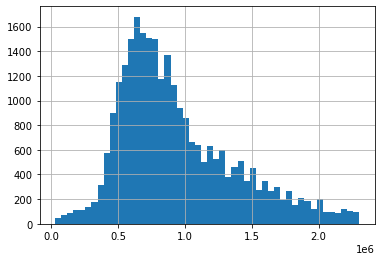

In [18]:
# Check distrobution of 

y.hist(bins=50)

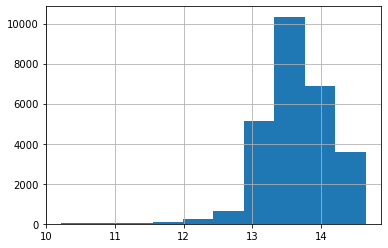

In [19]:
y_scld = np.log(y)
y_scld.hist();

In [20]:
# Run a baseline for the log of the target

y = y_scld
X = sm.add_constant(df['sqft_living'])

results = sm.OLS(y,X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.258
Method:                 Least Squares   F-statistic:                     9372.
Date:                Fri, 09 Dec 2022   Prob (F-statistic):               0.00
Time:                        11:34:09   Log-Likelihood:                -14892.
No. Observations:               26951   AIC:                         2.979e+04
Df Residuals:                   26949   BIC:                         2.980e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.9915      0.007   1801.300      0.000      12.977      13.006
sqft_living     0.0003   3.41e-06     96.810      0.000       0.000       0.000
==============================================================================
Omnibus:                     7740.531   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            47049.038
Skew:                          -1.242   Prob(JB):                         0.00
Kurtosis:                       8.977   Cond. No.                     5.95e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.95e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Exploration <a class="anchor" id="exp"></a>

In [ ]:
# Create heatmap of correlation of numericals and ordinals

sns.set(rc={'figure.figsize':(20, 20)})

nums_n_ords = df.iloc[:, 0:20]

mask  = np.triu(np.ones_like(nums_n_ords.drop('id', axis=1).corr()))
sns.heatmap(abs(nums_n_ords.drop('id', axis=1).corr()), annot=True, mask=mask)

In [ ]:
# Create heatmap of correlation of numericals and ordinals and dummies

sns.set(rc={'figure.figsize':(50, 50)})


mask  = np.triu(np.ones_like(df.drop('id', axis=1).corr()))
sns.heatmap(abs(df.drop('id', axis=1).corr()), annot=True, mask=mask)

In [ ]:
# Run pairplot of nums and ords

sns.pairplot(data=nums_n_ords);

# Improved Models <a class="anchor" id="impmods"></a>

## Highest R-Squared <a class="anchor" id="hir"></a>

In [21]:
# Run Model

y = df.price
X = sm.add_constant(df
                    [[
                        'sqft_living',
                        'price_cat',
                        'dist_high_zip',
                        'gr_above_avg',
                        'cond_above_avg',
                        'waterfront_YES_dum'
                    ]])
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     7611.
Date:                Fri, 09 Dec 2022   Prob (F-statistic):               0.00
Time:                        11:34:15   Log-Likelihood:            -3.7481e+05
No. Observations:               26951   AIC:                         7.496e+05
Df Residuals:                   26944   BIC:                         7.497e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.295e+05   8410.391     15.397      0.000    1.13e+05    1.46e+05
sqft_living          256.0461      2.488    102.901      0.000     251.169     260.923
price_cat           2.259e+05   2816.529     80.203      0.000     2.2e+05    2.31e+05
dist_high_zip      -9990.5213    180.420    -55.374      0.000   -1.03e+04   -9636.889
gr_above_avg        1.954e+05   5440.289     35.918      0.000    1.85e+05    2.06e+05
cond_above_avg      7.213e+04   3339.812     21.598      0.000    6.56e+04    7.87e+04
waterfront_YES_dum  2.402e+05   1.52e+04     15.815      0.000     2.1e+05     2.7e+05
==============================================================================
Omnibus:                     1826.565   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7715.452
Skew:                           0.203   Prob(JB):                         0.00
Kurtosis:                       5.589   Cond. No.                     1.99e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.99e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Lowest Cond. No. with R-squared > .6 <a class="abv6mod" id="feateng"></a>

In [22]:
df['log_price'] = np.log(df.price)
df['sqrt_dist_high_zip'] = np.sqrt(df.dist_high_zip)
df['log_sqft_living'] = np.log(df.sqft_living)

y = df.price
X = sm.add_constant(df
                    [[
                        'log_sqft_living',
                        'price_cat',
                        'dist_high_zip',
                        'gr_above_avg',
                        'cond_above_avg',
                        'waterfront_YES_dum'
                    ]])
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     7216.
Date:                Fri, 09 Dec 2022   Prob (F-statistic):               0.00
Time:                        11:34:15   Log-Likelihood:            -3.7526e+05
No. Observations:               26951   AIC:                         7.505e+05
Df Residuals:                   26944   BIC:                         7.506e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -2.711e+06   3.35e+04    -80.993      0.000   -2.78e+06   -2.65e+06
log_sqft_living     4.437e+05   4586.352     96.754      0.000    4.35e+05    4.53e+05
price_cat           2.273e+05   2865.436     79.333      0.000    2.22e+05    2.33e+05
dist_high_zip      -9793.3316    183.367    -53.408      0.000   -1.02e+04   -9433.922
gr_above_avg        2.455e+05   5368.080     45.734      0.000    2.35e+05    2.56e+05
cond_above_avg       6.86e+04   3395.270     20.205      0.000    6.19e+04    7.53e+04
waterfront_YES_dum  2.586e+05   1.54e+04     16.745      0.000    2.28e+05    2.89e+05
==============================================================================
Omnibus:                     2771.146   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14650.008
Skew:                           0.362   Prob(JB):                         0.00
Kurtosis:                       6.539   Cond. No.                         477.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
# Prepare price model table data for visualizations

price_mod_sum_table1 = model.summary()
results_as_html = price_mod_sum_table1.tables[1].as_html()
price_mod_table1 = pd.read_html(results_as_html, header=0, index_col=0)[0]

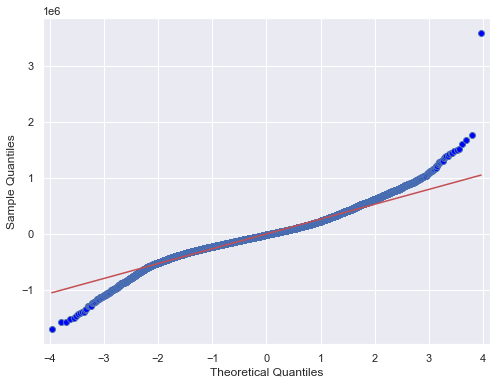

In [24]:
# Check qqplot

sns.set(rc={'figure.figsize':(8, 6)})
sm.qqplot(model.resid, line='r');

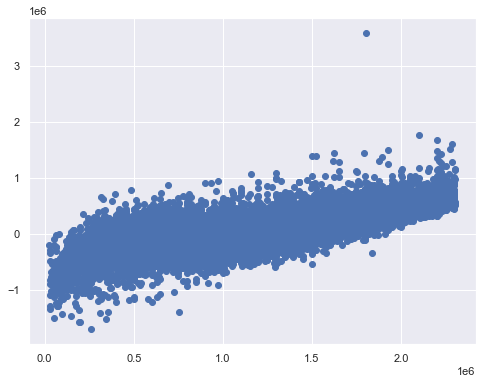

In [25]:
# Check homoskedasticity with resids scatter

model_preds = model.predict(X)
resids = y - model_preds

fig, ax = plt.subplots()

ax.scatter(y, resids);
#errors appear to be homoskedastic which is what we want

<AxesSubplot:ylabel='Count'>

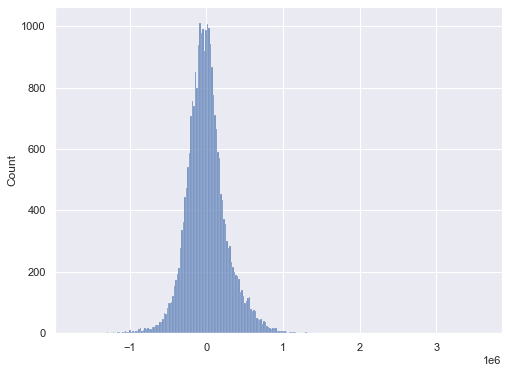

In [26]:
sns.histplot(x=resids)
#residual plot looks to be normally distributed

In [27]:
df_VIF = df[[
    'log_sqft_living',
    'price_cat',
    'dist_high_zip',
    'gr_above_avg',
    'cond_above_avg',
    'waterfront_YES_dum']]

vif=pd.DataFrame()
vif['feature'] = df_VIF.columns
vif["VIF"] = [variance_inflation_factor(df_VIF.values, i)
                          for i in range(len(df_VIF.columns))]

vif.sort_values('VIF',ascending=False)

#Might want to consider dropping a variable. VIF is high for the top 3

,feature,VIF
0,log_sqft_living,25.257603
1,price_cat,13.024246
2,dist_high_zip,6.093322
4,cond_above_avg,1.686581
3,gr_above_avg,1.231473
5,waterfront_YES_dum,1.023497


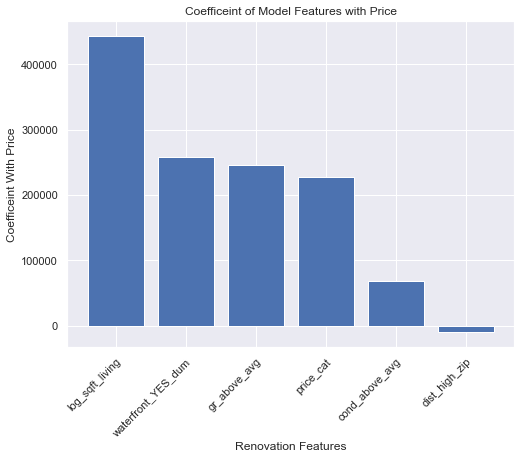

In [28]:
#Visualize Coefficients from Price Model

price_mod_table1_bar = price_mod_table1.sort_values('coef', ascending=False)
price_mod_table1_bar = price_mod_table1_bar.drop('const')

fig, ax = plt.subplots()

x = price_mod_table1_bar.index
y = price_mod_table1_bar['coef']

ax.set_xlabel("Renovation Features")
ax.set_ylabel("Coefficeint With Price")
ax.set_title("Coefficeint of Model Features with Price")

#ax.set_xticklabels(['Log SQRT Living Space', 'Bedrooms', 'Has Basement', 'Has Patio', 'Floors'])      
plt.xticks(rotation=45, ha = 'right', rotation_mode = 'anchor')  

ax.bar(x,y)

plt.savefig('images/coef_price_feats.png', bbox_inches='tight', dpi=300)

## Model With Renovation Features <a class="anchor" id="renomod"></a>

In [29]:
# Run home improvement model - model with renovation features

df['grade_squared'] = df['grade_enc']**2

y = df['price']
X = sm.add_constant(df[['price_cat',
                        'gr_above_avg',
                        'has_basement', 
                        'has_patio',   
                        'floors',
                        'bedrooms',
                        'bathrooms',
                        'cond_enc',
                       ]])

model = sm.OLS(y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.544
Method:                 Least Squares   F-statistic:                     4012.
Date:                Fri, 09 Dec 2022   Prob (F-statistic):               0.00
Time:                        11:34:17   Log-Likelihood:            -3.7760e+05
No. Observations:               26951   AIC:                         7.552e+05
Df Residuals:                   26942   BIC:                         7.553e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -3.132e+05   1.19e+04    -26.284      0.000   -3.37e+05    -2.9e+05
price_cat     3.154e+05   2639.560    119.478      0.000     3.1e+05    3.21e+05
gr_above_avg  3.148e+05   5805.889     54.226      0.000    3.03e+05    3.26e+05
has_basement  4.776e+04   3812.284     12.529      0.000    4.03e+04    5.52e+04
has_patio     2.916e+04   4414.820      6.605      0.000    2.05e+04    3.78e+04
floors         1.61e+04   3994.475      4.030      0.000    8267.427    2.39e+04
bedrooms      5.173e+04   2308.827     22.407      0.000    4.72e+04    5.63e+04
bathrooms     1.049e+05   3198.861     32.786      0.000    9.86e+04    1.11e+05
cond_enc      4.824e+04   2635.115     18.305      0.000    4.31e+04    5.34e+04
==============================================================================
Omnibus:                     1908.946   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4512.385
Skew:                           0.442   Prob(JB):                         0.00
Kurtosis:                       4.799   Cond. No.                         38.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
# Prepare renovations features model table data for visualizations

feats_mod_sum_table1 = model.summary()
results_as_html = feats_mod_sum_table1.tables[1].as_html()
feats_mod_table1 = pd.read_html(results_as_html, header=0, index_col=0)[0]

In [31]:
feats_mod_table1

,coef,std err,t,P>|t|,[0.025,0.975]
const,-313200.0,11900.000,-26.284,0.0,-337000.000,-290000.0
price_cat,315400.0,2639.560,119.478,0.0,310000.000,321000.0
gr_above_avg,314800.0,5805.889,54.226,0.0,303000.000,326000.0
has_basement,47760.0,3812.284,12.529,0.0,40300.000,55200.0
has_patio,29160.0,4414.820,6.605,0.0,20500.000,37800.0
floors,16100.0,3994.475,4.030,0.0,8267.427,23900.0
bedrooms,51730.0,2308.827,22.407,0.0,47200.000,56300.0
bathrooms,104900.0,3198.861,32.786,0.0,98600.000,111000.0
cond_enc,48240.0,2635.115,18.305,0.0,43100.000,53400.0


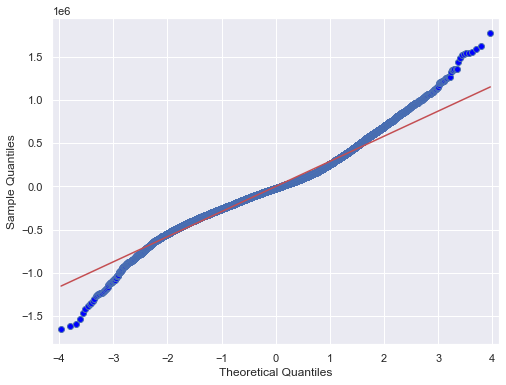

In [32]:
sm.qqplot(model.resid, line='r');

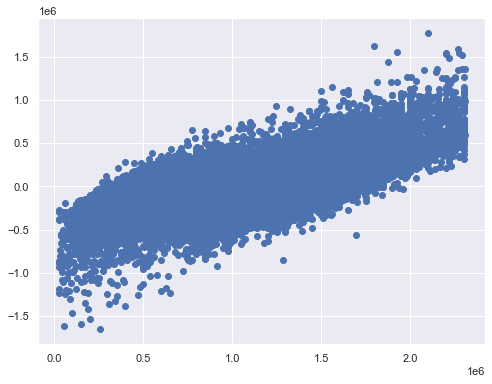

In [33]:
model_preds = model.predict(X)
resids = y - model_preds

fig, ax = plt.subplots()

ax.scatter(y, resids);

<AxesSubplot:ylabel='Count'>

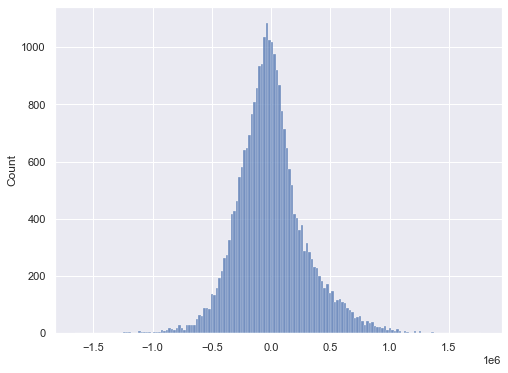

In [34]:
sns.histplot(x=resids)

In [35]:
df_VIF = df[['price_cat',
                        'gr_above_avg',
                        'has_basement', 
                        'has_patio',  
                        'floors',
                        'bedrooms',
                        'bathrooms',
                        'cond_enc',
                       ]]


vif=pd.DataFrame()
vif['feature'] = df_VIF.columns
vif["VIF"] = [variance_inflation_factor(df_VIF.values, i)
                          for i in range(len(df_VIF.columns))]

vif.sort_values('VIF',ascending=False)

,feature,VIF
6,bathrooms,17.642264
5,bedrooms,17.539841
4,floors,9.750319
7,cond_enc,9.175485
0,price_cat,8.070462
3,has_patio,4.570235
2,has_basement,2.122134
1,gr_above_avg,1.369986


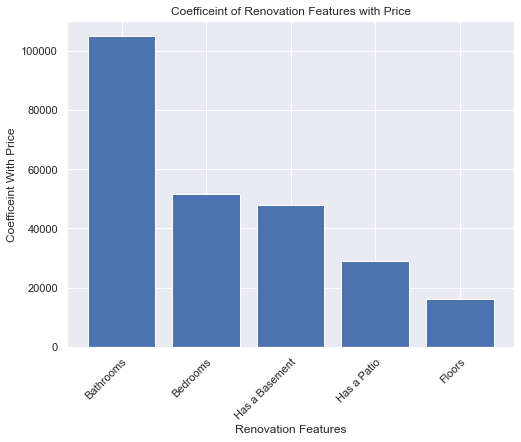

In [36]:
#Visualize Coefficients from Renovations Features Model

feats_mod_table1_bar = feats_mod_table1.sort_values('coef', ascending=False)
feats_mod_table1_bar = feats_mod_table1_bar.drop(['price_cat' , 'gr_above_avg', 'cond_enc', 'const'])

fig, ax = plt.subplots()

x = feats_mod_table1_bar.index
y = feats_mod_table1_bar['coef']

ax.set_xlabel("Renovation Features")
ax.set_ylabel("Coefficeint With Price")
ax.set_title("Coefficeint of Renovation Features with Price")

ax.set_xticklabels(['Bathrooms', 'Bedrooms', 'Has a Basement', 'Has a Patio', 'Floors'])      
plt.xticks(rotation=45, ha = 'right', rotation_mode = 'anchor')  

ax.bar(x,y)

plt.savefig('images/coef_reno_fets.png', bbox_inches='tight', dpi=300)

# Non-Model Analysis <a class="anchor" id="nonmod"></a>

To further understand the landscape of King Couty housing, we wanted to see the highest and lowest priced areas. We used zip codes taken from the addresses to plot the highest and lowest priced zip codes and created a boxplot of all zipcodes average price.

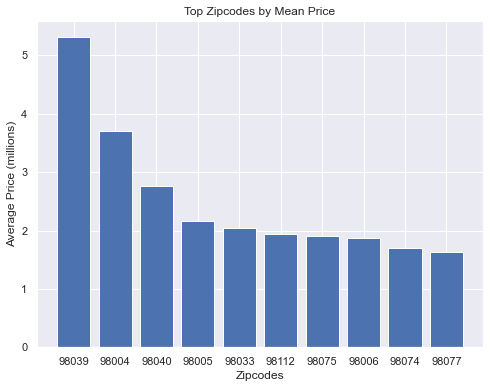

In [37]:
# Get top 10 highest average priced zips

zip_info = df[['zips', 'zip_mean']].drop_duplicates()
zip_top_10 = zip_info.sort_values('zip_mean', ascending=False)[0:10]
zip_top_10

fig, ax = plt.subplots()

x = zip_top_10['zips']
y = zip_top_10['zip_mean']/1000000

ax.set_xlabel("Zipcodes")
ax.set_ylabel("Average Price (millions)")
ax.set_title("Top Zipcodes by Mean Price")

ax.bar(x,y)

plt.savefig('images/top_zip_price.png', bbox_inches='tight', dpi=300)

In [38]:
zip_bot_10 = zip_info.sort_values('zip_mean', ascending=True)[0:10]
zip_bot_10

,zips,zip_mean
8023,98224,254666.666667
18449,98422,312750.000000
1765,98288,457268.750000
44,98002,475426.217631
389,98047,492911.792208
7476,98251,515300.000000
32,98168,538955.477807
2080,98354,574159.260870
448,98032,581496.201087
86,98003,606754.711364


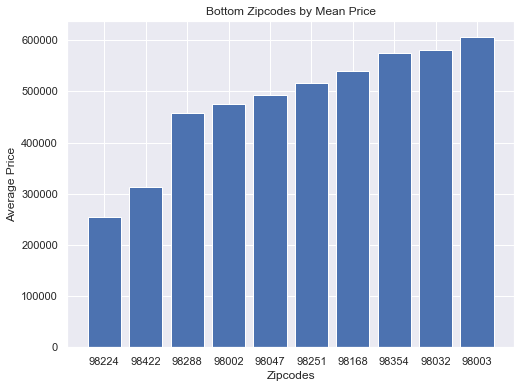

In [39]:
# Get top 10 lowest average priced zips

zip_bot_10 = zip_info.sort_values('zip_mean', ascending=True)[0:10]

fig, ax = plt.subplots()

x = zip_bot_10['zips']
y = zip_bot_10['zip_mean']

ax.set_xlabel("Zipcodes")
ax.set_ylabel("Average Price")
ax.set_title("Bottom Zipcodes by Mean Price")

ax.bar(x,y)

plt.savefig('images/bot_zips_price.png', bbox_inches='tight', dpi=300)

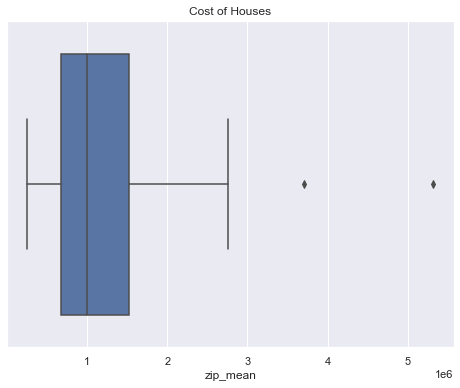

In [40]:
# Create a box plot of average means

sns.boxplot(zip_info.zip_mean).set(title='Cost of Houses')

plt.savefig('images/zip_box.png', bbox_inches='tight', dpi=300)

### Size of House

Our models indicated a high importance of the square footage of the house to price. We wanted to look at the average cost of houses by square footage. As expected, as houses increased in size, so does averae price.

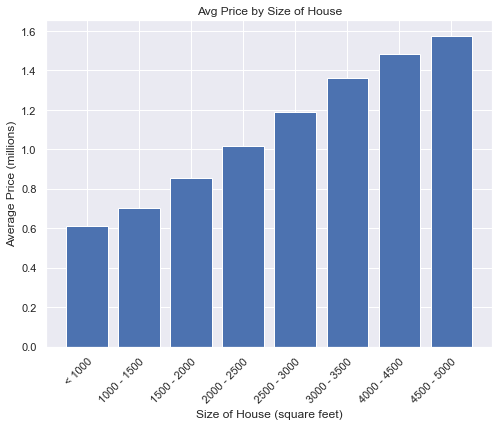

In [41]:
# Visualize average prize of size of house

sq_cat_an_price = df[['sqft_cat', 'price']]
sq_cat_an_price = sq_cat_an_price.groupby('sqft_cat').mean('price')

fig, ax = plt.subplots()

x = sq_cat_an_price.index
y = sq_cat_an_price.price/1000000

ax.set_xlabel("Size of House (square feet)")
ax.set_ylabel("Average Price (millions)")
ax.set_title("Avg Price by Size of House")

plt.xticks(np.arange(10), ['', '< 1000', '1000 - 1500','1500 - 2000', 
                          '2000 - 2500', '2500 - 3000', '3000 - 3500',
                          '4000 - 4500', '4500 - 5000', '> 5000'])

plt.xticks(rotation=45, ha = 'right', rotation_mode = 'anchor')

ax.bar(x,y)

plt.savefig('images/sqft_cat_mean_price.png', bbox_inches='tight', dpi=300)

### Waterfront

Waterfront properties have a generally higher value. We wanted to see how often waterfront homes were sold and where they sold the most.

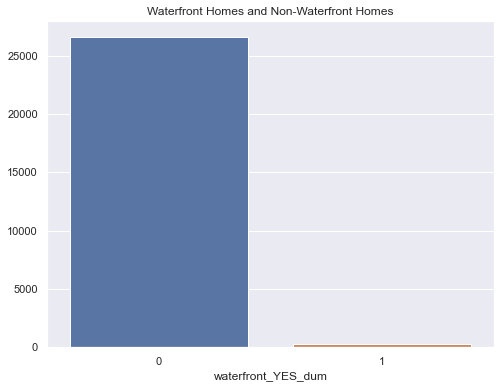

In [42]:
# Visualize amount of waterfront homes
waterfront_homes = df.value_counts('waterfront_YES_dum')
sns.barplot(waterfront_homes.index, waterfront_homes.values, ).set(title='Waterfront Homes and Non-Waterfront Homes')

plt.savefig('images/wat_amt.png', bbox_inches='tight', dpi=300)

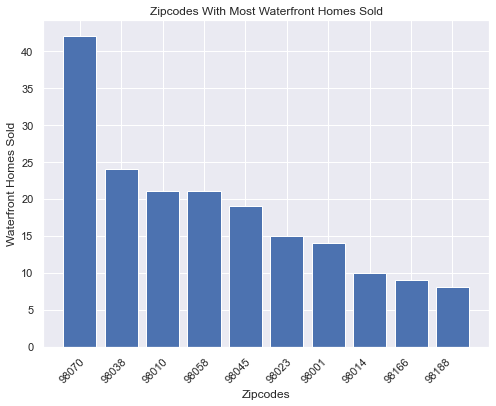

In [43]:
# Get zips with most waterfronts sold

df_zips_an_water = df[['zips', 'waterfront_YES_dum']]
df_zips_water = df_zips_an_water.groupby('zips').sum('waterfront_YES_dum').sort_values('waterfront_YES_dum', ascending=False)
df_zips_water = df_zips_water[df_zips_water['waterfront_YES_dum'] > 0]
df_zips_water
wat_top_10 = df_zips_water[0:10]

# Create visualization of top 10 zips with watetfront homes sold
fig, ax = plt.subplots()

x = wat_top_10.index
y = wat_top_10['waterfront_YES_dum']

ax.set_xlabel("Zipcodes")
ax.set_ylabel("Waterfront Homes Sold")
ax.set_title("Zipcodes With Most Waterfront Homes Sold")

plt.xticks(rotation=45, ha = 'right', rotation_mode = 'anchor')

ax.bar(x,y)

plt.savefig('images/zips_water.png', bbox_inches='tight', dpi=300)

### Distance from Madina

We saw in our map that there was a cluster of high priced areas. We knew the highest priced zipcode was in this cluster and wanted to see the relationship between distance from this zip code and price. We created three price categories and foudn their average distance from the highest priced zipcode.

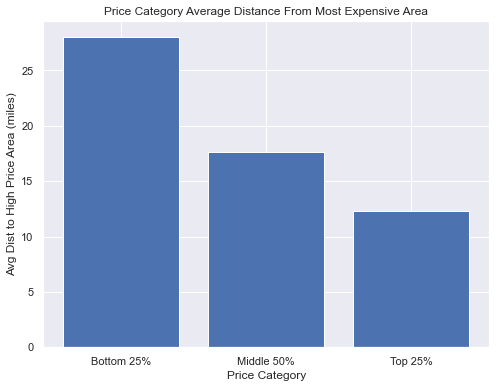

In [44]:
# Get average distance from highest zip by price category

price_an_dist = df[['price_cat', 'dist_high_zip']]
pricecat_dist = price_an_dist.groupby('price_cat').mean('dist_high_zip')

# Visualize

fig, ax = plt.subplots()

x = pricecat_dist.index
y = pricecat_dist['dist_high_zip']

ax.set_xlabel("Price Category")
ax.set_ylabel("Avg Dist to High Price Area (miles)")
ax.set_title("Price Category Average Distance From Most Expensive Area")

# ha = ['right', 'center', 'left']

plt.xticks(np.arange(4), ['', 'Bottom 25%', 'Middle 50%', 'Top 25%'])

ax.bar(x,y)

plt.savefig('images/price_cats.png', bbox_inches='tight', dpi=300)

### Condition Rating

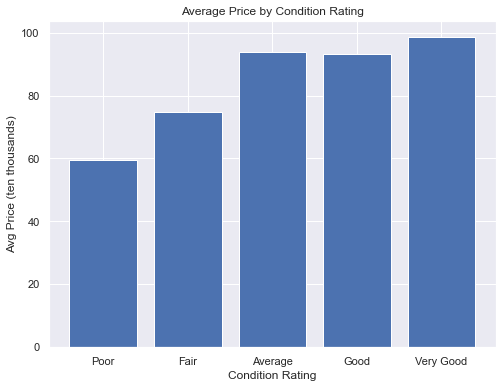

In [45]:
# Create visualization of averge price by condition rating

price_an_cond = df[['cond_enc', 'price']]
price_cond = price_an_cond.groupby('cond_enc').mean('price')

fig, ax = plt.subplots()

x = price_cond.index
y = price_cond['price']/10000

ax.set_xlabel("Condition Rating")
ax.set_ylabel("Avg Price (ten thousands)")
ax.set_title("Average Price by Condition Rating")

# ha = ['right', 'center', 'left']

plt.xticks(np.arange(5), ['Poor', 'Fair', 'Average','Good','Very Good'])

ax.bar(x,y)

plt.savefig('images/ang_price_cond.png', bbox_inches='tight', dpi=300)

# Ignore Everything Below Here!

In [ ]:
sq_cat_an_price.groupby

In [ ]:
sq_cat_an_price = sq_cat_an_price.groupby('sqft_cat').mean('price')

In [ ]:
int(sq_cat_an_price.iloc[2]) - int(sq_cat_an_price.iloc[1])

In [ ]:
int(sq_cat_an_price.iloc[3]) - int(sq_cat_an_price.iloc[2])

In [ ]:
int(sq_cat_an_price.iloc[4]) - int(sq_cat_an_price.iloc[3])

In [ ]:
int(sq_cat_an_price.iloc[5]) - int(sq_cat_an_price.iloc[4])

In [ ]:
int(sq_cat_an_price.iloc[6]) - int(sq_cat_an_price.iloc[5])

In [ ]:
int(sq_cat_an_price.iloc[7]) - int(sq_cat_an_price.iloc[6])

In [ ]:
int(sq_cat_an_price.iloc[8]) - int(sq_cat_an_price.iloc[7])

In [ ]:
int(sq_cat_an_price.iloc[7]) - int(sq_cat_an_price.iloc[6])

In [ ]:
int(sq_cat_an_price.iloc[3])

In [ ]:
sns.barplot(sq_cat_an_price.index, sq_cat_an_price.price)

In [ ]:
df['price'].mean()

In [ ]:
sns.boxplot(df.sqft_living).set(title='house size')

In [ ]:
df.sqft_cat.value_counts()

In [ ]:
# Get top 10 highest average priced zips

zip_info = df[['zips', 'zip_mean']].drop_duplicates()
zip_top_10 = zip_info.sort_values('zip_mean', ascending=False)[0:10]
zip_top_10

sns.barplot(zip_top_10['zips'], zip_top_10['zip_mean'], ).set(title='Top 10 Price Zips')

In [ ]:
# Get top 10 highest average priced zips

sns.barplot(zip_bot_10['zips'], zip_bot_10['zip_mean'], ).set(title='Top 10 Price Zips')

In [ ]:
df.zip_mean.describe()

In [ ]:
# Get the higest correlated features to price
# Removed directly price related features except for zip_mean

df_corrs = df.corr()['price'].map(abs).sort_values(ascending=False)
df_corrs = df_corrs.drop(['price', 'log_price', 'lat', 'price_cat', 'sqrt_dist_high_zip', 'dist_high_zip'])
top_10_corrs = df_corrs[0:10]

sns.set(rc={'figure.figsize':(12, 6)})

sns.barplot(top_10_corrs.index, top_10_corrs.values).set(title='Top 10 Price Correlated Features')
plt.xticks(rotation=45)

In [ ]:
# Show scatter of beds and baths
# I think this should be a two axis figure showing beds and baths with price. JJ will create this Thusday


sns.set(rc={'figure.figsize':(6, 6)})

sns.scatterplot(df['bedrooms'],df['price']).set(title='Price and Bedrooms')

In [ ]:
df.corr()['price']['bedrooms']

In [ ]:
sns.set(rc={'figure.figsize':(6, 6)})

sns.scatterplot(df['bathrooms'],df['price']).set(title='Price and Bathrooms')

In [ ]:
df.corr()['price']['bathrooms']

In [ ]:
# Create bar vizs of coeeficients and correlations of renovation option features

feats_mod_table1

In [ ]:
sns.set(rc={'figure.figsize':(12, 6)})

feats_mod_table1_bar = feats_mod_table1.drop(labels=['const', 'price_cat', 'gr_above_avg', 'cond_enc'])

sns.barplot(feats_mod_table1_bar.index, feats_mod_table1_bar['coef']).set(title='Coefficeint of Renovation Features to Price')
plt.xticks(rotation=45)

In [ ]:
feats_mod_table1_bar = feats_mod_table1_bar.sort_values('coef', ascending=False)

In [ ]:
#Visualize Coefficients from Renovations Features Model

feats_mod_table1_bar = feats_mod_table1_bar.sort_values('coef', ascending=False)

fig, ax = plt.subplots()

x = feats_mod_table1_bar.index
y = feats_mod_table1_bar['coef']

ax.set_xlabel("Renovation Features")
ax.set_ylabel("Coefficeint With Price")
ax.set_title("Coefficeint of Renovation Features with Price")

ax.set_xticklabels(['Bathrooms', 'Bedrooms', 'Has Basement', 'Has Patio', 'Floors'])      
plt.xticks(rotation=45, ha = 'right', rotation_mode = 'anchor')  

ax.bar(x,y)

In [ ]:
fig, ax = plt.subplots()

x = feats_mod_table1_bar.index
y = feats_mod_table1_bar['coef']

ax.set_xlabel("Renovation Features")
ax.set_ylabel("Coefficient of Price")
ax.set_title("Correlation of Renovation Features to Price")

# ax.set_xticklabels(['Bathrooms', 'Bedrooms', 'Floors', 'Has Patio', 'Has Basement', 'Has Garage', 'Condition Rating'])      
plt.xticks(rotation=45, ha = 'right', rotation_mode = 'anchor')  

ax.bar(x,y)

In [ ]:
feats_reno_bar_corr = df[['price',
                        'has_basement', 
                        'has_patio', 
                        'has_garage',  
                        'floors',
                        'bedrooms',
                        'bathrooms',
                       ]]
feats_reno_bar = feats_reno_bar_corr.corr()['price']

In [ ]:
feats_reno_bar = feats_reno_bar.drop('price')
feats_reno_bar.sort_values(ascending=False, inplace=True)

In [ ]:
sns.barplot(feats_reno_bar.index, feats_reno_bar.values, ).set(title='Coefficeint of Renovation Features to Price')

In [ ]:
fig, ax = plt.subplots()

x = feats_reno_bar.index
y = feats_reno_bar.values

ax.set_xlabel("Renovation Features")
ax.set_ylabel("Correlation with Price")
ax.set_title("Correlation of Renovation Features to Price")

ax.set_xticklabels(['Bathrooms', 'Bedrooms', 'Floors', 'Has Patio', 'Has Basement', 'Has Garage'])      
plt.xticks(rotation=45, ha = 'right', rotation_mode = 'anchor')  

ax.bar(x,y)

#plt.savefig('images/top_studios_filt_gross.png', bbox_inches='tight')

In [ ]:
waterfront_homes = df.value_counts('waterfront_YES_dum')
waterfront_homes

In [ ]:
wat_top_10

In [ ]:
# Get zips with most waterfronts sold

df_zips_an_water = df[['zips', 'waterfront_YES_dum']]
df_zips_water = df_zips_an_water.groupby('zips').sum('waterfront_YES_dum').sort_values('waterfront_YES_dum', ascending=False)
df_zips_water = df_zips_water[df_zips_water['waterfront_YES_dum'] > 0]
df_zips_water
wat_top_10 = df_zips_water[0:10]

# Create visualization of top 10 zips with watetfront homes sold
sns.barplot(wat_top_10.index, wat_top_10['waterfront_YES_dum'], ).set(title='Zipcodes With Most Waterfront Homes Sold')

In [ ]:
df.columns

In [ ]:
# Get average distance from highest zip by price category

price_an_dist = df[['price_cat', 'dist_high_zip']]
pricecat_dist = price_an_dist.groupby('price_cat').mean('dist_high_zip')

# Create viz
sns.barplot(pricecat_dist.index, pricecat_dist['dist_high_zip']).set(title='Price Category Average Distance From Most Expensive Are')

In [ ]:

price_cond


In [ ]:
price_cond.index

In [ ]:
price_cond['price']

In [ ]:
df['price'].describe()

In [ ]:
sns.boxenplot(df['price'])

In [ ]:
df.columns

In [ ]:
# # Scale all

# df_no_price = df.drop(['price'], axis=1)

# df_scaled = (df_no_price - np.mean(df_no_price)) / np.std(df_no_price)

In [ ]:
# # Model all features sclaed

# y = y
# X = sm.add_constant(df_scaled.drop(['id', 'long', 'lat'], axis=1))

# results = sm.OLS(y,X).fit()
# results.summary()

In [ ]:
# Run model with sqft_living and grade_enc, the two higest correlations to price at this point

# Get sqaure foot living and grade encoded and concatonate
df_gr_enc = pd.DataFrame(df.grade_enc)
df_sq_ft = pd.DataFrame(df.sqft_living)
X3 = pd.concat([df_sq_ft, df_gr_enc], axis=1)

y = df['price']
X = sm.add_constant(X3)

# Run model
results = sm.OLS(y,X).fit()
results.summary()

In [ ]:
sns.histplot(df['sqft_garage'], kde=True)

In [ ]:
df['al300_sqft_garage'] = df['sqft_garage'] > 300

y = df['price']
X = sm.add_constant(df['sqft_garage'])

# Run model
results = sm.OLS(y,X).fit()
results.summary()

In [ ]:
df['al300_sqft_garage'] = df['sqft_garage'] > 300

y = y_scld
X = sm.add_constant(df[['sqft_garage','grade_enc', 'price_cat']])

# Run model
results = sm.OLS(y,X).fit()
results.summary()

In [ ]:
df['al300_sqft_garage'] = df['sqft_garage'] > 300

y = df['price']
X = sm.add_constant(df['grade_enc'])

# Run model
results = sm.OLS(y,X).fit()
results.summary()

In [ ]:
df[['sqft_garage','grade_enc']]


In [ ]:
sns.histplot(df['sqft_living'], kde=True)

In [ ]:
df.corr()['price']['sq_liv_log']


In [ ]:
df['sq_abv_log'] = np.log(df['sqft_above'])
sns.histplot(df['sq_abv_log'], kde=True)
df.corr()['price']['sq_abv_log']

In [ ]:
df['sq_abv_log'] = np.log(df['sqft_above'])
sns.histplot(df['sq_abv_log'], kde=True)
df.corr()['price']['sq_abv_log']

In [ ]:
df['has_basement'] = 

In [ ]:
sns.histplot(df['sqft_garage'], kde=True)

In [ ]:
df['has_garage'] = [1 if x > 0 else 0 for x in df['sqft_garage']]
df['has_basement'] = [1 if x > 0 else 0 for x in df['sqft_basement']]
df['has_patio'] = [1 if x > 0 else 0 for x in df['sqft_patio']]
df['has_garage']

In [ ]:
df.corr()['price']['has_garage']
#sns.histplot(df['has_garage'], kde=True)

In [ ]:
df['has_basement'] = [1 if x > 0 else 0 for x in df['sqft_basement']]
df['has_basement']

In [ ]:
df['has_patio'] = [1 if x > 0 else 0 for x in df['sqft_patio']]
df['has_patio']

In [ ]:
df.corr()['price']['has_patio']
#sns.histplot(df['has_garage'], kde=True)

In [ ]:
df.corr()['price']['has_basement']
#sns.histplot(df['has_garage'], kde=True)

# HERE

In [ ]:
# Run baseline model

sqft_log = np.log(df.sqft_living)

y = df['price']
X = sm.add_constant(df[['zip_mean', 'sqft_living' ]])

results = sm.OLS(y,X).fit()
results.summary()

In [ ]:
df['grade_squared'] = df['grade_enc']**2

In [ ]:
df_VIF = df[['price_cat',
             'grade_enc',
             'has_basement', 
             'has_patio', 
             'has_garage',  
             'floors',
             'bedrooms',
             'bathrooms',
             'cond_enc',
            ]]


vif=pd.DataFrame()
vif['feature'] = df_VIF.columns
vif["VIF"] = [variance_inflation_factor(df_VIF.values, i)
                          for i in range(len(df_VIF.columns))]

vif.sort_values('VIF',ascending=False)

In [ ]:
df['yard'] =  df.sqft_living / df.sqft_lot

In [ ]:
df.corr()['price']['yard']

In [ ]:
df.corr()['price']['sqft_above']

In [ ]:
y = y
X = sm.add_constant(df[['has_basement', 'view_enc',  'has_patio', 'has_garage', 'bedrooms', 'bathrooms', 'floors', 'price_cat', 'dist_bellevue']])

# Run model
results = sm.OLS(y,X).fit()
results.summary()

In [ ]:
y = y
X = sm.add_constant(df[['has_basement', 'view_enc',  'has_patio', 'has_garage', 'bedrooms', 'bathrooms', 'floors', 'price_cat', 'dist_bellevue']])

# Run model
results = sm.OLS(y,X).fit()
results.summary()

In [ ]:
y = y_scld
X = sm.add_constant(df[['has_basement', 'view_enc',  'has_patio', 'has_garage', 'bedrooms', 'bathrooms', 'floors', 'price_cat', 'dist_bellevue']])

# Run model
results = sm.OLS(y,X).fit()
results.summary()

In [ ]:
y = y
X = sm.add_constant(df[['price_cat', 'dist_bellevue']])

# Run model
results = sm.OLS(y,X).fit()
results.summary()

In [ ]:
df['sqft_above_log'] = np.log(df.sqft_above)

In [ ]:
y = y
X = sm.add_constant(df[['sqft_above_log', 'has_basement', 'bathrooms']])

# Run model
results = sm.OLS(y,X).fit()
results.summary()

In [ ]:
# Loo sqft per 

In [ ]:
y = y
X = sm.add_constant(df[['bedrooms', 'bathrooms', 'has_basement', 'has_patio', 'has_garage', ]])

# Run model
results = sm.OLS(y,X).fit()
results.summary()

In [ ]:
# Create function that identifies outliers

def find_outliers_IQR(df):
   q1=df.quantile(0.25)
   q3=df.quantile(0.75)
   IQR=q3-q1
   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
   return outliers

In [ ]:
find_outliers_IQR(df['sqft_living'])

In [ ]:
# Create a column of mean prices by zip

# Get zip code form address

df['zip'] = df['address'].str.extract(r'(\d{5}\-?\d{0,4})')
df['zip'].head(50)

#Creaet dict of mean prices by zip code
zips_avg_prices = df.groupby(df.zip).mean()['price']
zip_mean_dict = zips_avg_prices.to_dict()

# Map mean proce by zip into new column
df['zip_mean'] = df['zip'].map(zip_mean_dict)
df['zip_mean']

Create zip price mean category column

price_cat = []

for price in df['zip_mean']:
    if price < 714997.7:
        price_cat.append(1)
    elif price < 1320000:
        price_cat.append(2)
    else:
        price_cat.append(3)
        
df['price_cat'] = price_cat

In [ ]:
get_outliers(df['price'])

In [ ]:
get_outliers(df['sqft_living'])

In [ ]:
get_outliers(df['sqft_above'])

In [ ]:
df_less_outs = df[df['price'] < 2309000]
df_less_outs = df_less_outs[df_less_outs['sqft_living'] < 4450]
df_less_outs = df_less_outs[df_less_outs['sqft_above'] < 3950]
df = df_less_outs

In [ ]:
df['sqft_lot'].describe()

In [ ]:
# sns.boxenplot(df['sqft_living'])
sns.boxplot(df['sqft_living'])

In [ ]:
sns.histplot(df['sqft_living'], kde=True)

In [ ]:
df['sqft_living'].quantile()

In [ ]:
sns.histplot(df['sqft_garage'], kde=True)

In [ ]:
df['patio_gr_one'] = df['sqft_patio'] > 1
df['patio_gr_one'] = df.patio_gr_one.astype(int)

df.corr()['price']['patio_gr_one']

In [ ]:
df.corr

In [ ]:
sns.histplot(patio_gr_one, kde=True)

In [ ]:
df['sqft_per_bath'] = df.sqft_living / df.bathrooms
df.corr()['price']['sqft_per_bath']

In [ ]:
df['bath_per_sqft'] = df.bathrooms / df.sqft_living
df.corr()['price']['bath_per_sqft']

In [ ]:
# sf living per sf lot

In [ ]:
df['sqft_per_lot'] = df.sqft_living / df.sqft_lot
df.corr()['price']['sqft_per_lot']

In [ ]:
df['bath_per_bed'] = df.bathrooms / df.bedrooms
df.corr()['price']['bath_per_bed']

In [ ]:

df.corr()['price']['price_cat']

# Everything below here is a mess

In [ ]:
pf = PolynomialFeatures(degree=2)

X = df.drop('price', axis=1)
y = df.price

pf.fit(X)

pdf = pd.DataFrame(pf.transform(X), columns=pf.get_feature_names())

pdf.head()

In [ ]:
df.zip_mean.describe()

In [ ]:
# lr = LinearRegression().fit(pdf,y)
# lr.score(pdf,y)

In [ ]:
whole = pd.concat([pdf,y], axis=1)

In [ ]:
whole_corr = whole.corr()['price'].sort_values(ascending=False)

In [ ]:
whole_corr.sort_values(ascending=False)

In [ ]:
y = df['price']
X = sm.add_constant(whole[['x3 x16', 'x2 x3', 'x6 x16']])

# Run model
results = sm.OLS(y,X).fit()
results.summary()

In [ ]:
y = df['price']
X = sm.add_constant(whole['x3 x16'])

# Run model
results = sm.OLS(y,X).fit()
results.summary()

In [ ]:
data_categorical = pd.DataFrame(df.select_dtypes("object")).drop(['date','address'], axis=1)
data_categorical.head()

In [ ]:
cat_data = data_categorical[['waterfront', 'greenbelt', 'nuisance', 'heat_source', 'sewer_system']]
ordinal_data = data_categorical[['view', 'condition', 'grade']]

In [ ]:
cat_dums = pd.get_dummies(cat_data)
cat_dums = cat_dums.add_suffix('_dum')
cat_dums

In [ ]:
pd.get_dummies(cat_data, drop_first=True)

In [ ]:
df['grade'].value_counts()

In [ ]:
pd.DataFrame(ordinal_data['grade'])

In [ ]:
cat_wat = pd.DataFrame(cat_data.waterfront)
cat_wat

In [ ]:
ohe = OneHotEncoder(sparse=False)
ohe.fit(cat_wat)
wat_encoded = ohe.transform(cat_wat)
wat_encoded = pd.DataFrame(wat_encoded).add_prefix('wat_')
wat_encoded

In [ ]:
ohe = OneHotEncoder(sparse=False)
ohe.fit(pd.DataFrame(cat_data['waterfront']))
waterfront_enc = ohe.transform(pd.DataFrame(cat_data['waterfront']))


In [ ]:
waterfront_enc

In [ ]:
pd.DataFrame(waterfront_enc)

In [ ]:
cat_encoded

In [ ]:
pd.DataFrame(cat_encoded)

In [ ]:
y = df['price']
X = sm.add_constant(df['sqft_living'])

results = sm.OLS(y,X).fit()
results.summary()

In [ ]:
y = df['price']
X = sm.add_constant(view_encoded)

results = sm.OLS(y,X).fit()
results.summary()

In [ ]:
y = df['price']
X = sm.add_constant(grade_encoded)

results = sm.OLS(y,X).fit()
results.summary()

In [ ]:
y = df['price']
X = sm.add_constant(cond_encoded)

results = sm.OLS(y,X).fit()
results.summary()

In [ ]:
df_gr_enc = pd.DataFrame(df.grade_enc)
df_sq_ft = pd.DataFrame(df.sqft_living)

X3 = pd.concat([df_sq_ft, df_gr_enc], axis=1)

y = df['price']
X = sm.add_constant(X3)

results = sm.OLS(y,X).fit()
results.summary()

In [ ]:
y = df['price']
X = sm.add_constant(X3)

results = sm.OLS(y,X).fit()
results.summary()

In [ ]:
sns.set(rc={'figure.figsize':(12, 12)})

mask  = np.triu(np.ones_like(concat_all.drop('id', axis=1).corr()))
sns.heatmap(abs(concat_all.drop('id', axis=1).corr()), annot=True, mask=mask)

In [ ]:
df_sq_ftb = pd.DataFrame(df['sqft_basement'])
df_sq_ftb

In [ ]:
X4 = pd.DataFrame(np.hstack([df_sq_ft, df_gr_enc, df_sq_ftb]))

In [ ]:
y = df['price']
X = sm.add_constant(X4)

results = sm.OLS(y,X).fit()
results.summary()

In [ ]:
sft_living
bathrooms
